In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import copy
import json
from tqdm import tqdm
import pickle
import logging
import math
import matplotlib
from re import S
import collections
from hmmviz import TransGraph
from scipy.stats.stats import pearsonr  
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

In [12]:

with open('../data/data_labeled_study.pkl', 'rb') as f:
    logs_by_user_session_labeled = pickle.load(f)


# Section 6.1: Time Spent in various CUPSs

## For figures 6a and 6c, please see the notebooks viz_draw.ipynb

## Figure 6b

In [13]:
all_states = []
all_actions = []
all_times = []
all_states_continuous = []
all_states_list = []
all_times_list = []

all_times_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(last_state)
            last_state = states[i]
            times_continuous.append(times_cumalitive)
            times_cumalitive = times[i]
        else:
            times_cumalitive += times[i]
    states_continuous.append(last_state)
    times_continuous.append(times_cumalitive)
    
    all_states_list.extend(states)
    all_times_list.extend(times)
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)


In [14]:
states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used

states_count = [[0 for i in range(len(states_unique))] for _ in range(len(all_states))]
for i in range(len(all_states)):
    for j in range(len(all_states[i])):
        states_count[i][states_unique.index(all_states[i][j])] += all_times[i][j]
# normalize
states_count = [[i/sum(states_count_single)*100 for i in states_count_single] for states_count_single in states_count]
averaged_over_users = np.mean(states_count, axis=0)
# print
print('Averaged Across Users \n \n')
for i in range(len(states_unique)):
    print(f' {states_unique[i]}  {averaged_over_users[i]:.2f}')


Averaged Across Users 
 

 Editing Written Code(C)  4.28
 Thinking About New Code To Write (F)  10.91
 Writing New Functionality (Z)  14.05
 Deferring Thought For Later (D)  1.39
 Looking up Documentation (N)  7.45
 Debugging/Testing Code (H)  11.31
 Not Thinking (S)  0.00
 Waiting For Suggestion (G)  4.20
 Editing Last Suggestion (X)  11.90
 Prompt Crafting (V)  11.56
 Writing Documentation (B)  0.53
 Thinking/Verifying Suggestion (A)  22.40


In [15]:
states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used
states_count = [0 for i in range(len(states_unique))]
states_freq = {}
for i in range(len(all_states)):
    for j in range(len(all_states[i])):
        states_count[states_unique.index(all_states[i][j])] += all_times[i][j]
# normalize
states_count = [i/sum(states_count)*100 for i in states_count]
print('Averaged Across All Sessions \n \n')
for i in range(len(states_count)):
    print(f' {states_unique[i]}  {states_count[i]:.2f}')
    states_freq[states_unique[i]] = states_count[i]

Averaged Across All Sessions 
 

 Editing Written Code(C)  4.46
 Thinking About New Code To Write (F)  12.77
 Writing New Functionality (Z)  13.34
 Deferring Thought For Later (D)  1.34
 Looking up Documentation (N)  7.38
 Debugging/Testing Code (H)  11.56
 Not Thinking (S)  0.01
 Waiting For Suggestion (G)  4.59
 Editing Last Suggestion (X)  11.22
 Prompt Crafting (V)  11.08
 Writing Documentation (B)  0.44
 Thinking/Verifying Suggestion (A)  21.82


In [20]:
# get unique states
from scipy import stats as st

states_unique = list(set(all_states_continuous))
# for each state get average time spent in state
all_states_list
states_time = {}
for i in range(len(all_states_list)):
    # check if already in dict
    if all_states_list[i] in states_time:
        states_time[all_states_list[i]].append(all_times_list[i])
    else:
        states_time[all_states_list[i]] = [all_times_list[i]]
# get average time spent in state
states_time_avg = {}
for s in states_time:
    # get 90% confidence interval for states_time[s] which is a list of times
    confidence_interval = st.t.interval(0.90, len(states_time[s])-1, loc=np.mean(states_time[s]), scale=st.sem(states_time[s]))
    states_time_avg[s] = [np.mean(states_time[s]), np.median(states_time[s]), np.std(states_time[s]), confidence_interval]
# sort states by average time spent in state
# print
for s in states_time_avg:
    print(f' state {s} avg time {states_time_avg[s][0]:.2f} median time {states_time_avg[s][1]:.2f} std time {states_time_avg[s][2]:.2f}')


 state Thinking/Verifying Suggestion (A) avg time 5.29 median time 1.22 std time 11.87
 state Looking up Documentation (N) avg time 75.84 median time 62.78 std time 75.20
 state Prompt Crafting (V) avg time 1.91 median time 0.26 std time 6.86
 state Thinking About New Code To Write (F) avg time 8.27 median time 0.86 std time 22.61
 state Writing New Functionality (Z) avg time 3.03 median time 0.46 std time 8.19
 state Editing Last Suggestion (X) avg time 9.82 median time 1.14 std time 20.91
 state Debugging/Testing Code (H) avg time 13.60 median time 1.30 std time 24.57
 state Editing Written Code(C) avg time 7.16 median time 0.60 std time 21.09
 state Waiting For Suggestion (G) avg time 4.18 median time 1.03 std time 11.09
 state Writing Documentation (B) avg time 3.98 median time 0.86 std time 9.56
 state Deferring Thought For Later (D) avg time 2.41 median time 1.31 std time 3.15
 state Not Thinking (S) avg time 1.19 median time 1.19 std time 0.00


/home/hussein/miniconda3/envs/hussein/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/hussein/miniconda3/envs/hussein/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
from hmmviz import TransGraph
import pandas as pd
import matplotlib.pyplot as plt


T = pd.crosstab(
    pd.Series(all_states_list[:-1], name='Today'),
    pd.Series(all_states_list[1:], name='Tomorrow'),
    normalize=0
)
'''
T = pd.crosstab(
    pd.Series(all_states_continuous[:-1], name='Today'),
    pd.Series(all_states_continuous[1:], name='Tomorrow'),
    normalize=0
)
'''
graph = TransGraph(T)
transition_matrix = np.array(graph.dataframe)
nodes = list(graph.dataframe.index)
# take each string in nodes and add new line if more than 2 words in string
nodes_new = []
for i in range(len(nodes)):
    if len(nodes[i].split(' ')) > 2:
        words = nodes[i].split(' ')
        temp_str = ''
        added_line = False
        for j in range(len(words)-1):
            temp_str += words[j] +' ' 
            if (j == 1 or len(temp_str)> 15) and not added_line:
                temp_str += '\n'
                added_line = True
        nodes_new.append(temp_str)
    else:
        nodes_new.append(nodes[i])
nodes = nodes_new
nodes[3] = 'Editing Written \n Code'
nodes[-2] = 'Writing \n Documentation '
labels_nodes = {}
# color nodes
frequencies = [11.31, 1.39, 11.9,4.28,7.45,0.01,11.56,10.91,22.4,4.2,0.53,14.05]
avg_times = [29.24,  7.34, 24.22, 14.08, 106.51, 11.08, 10.67, 19.67, 10.58, 10.54,  9.12, 13.60]
for i in range(len(nodes)):
    #nodes[i] = nodes[i] + f' \n {avg_times[i]:.2f}s , {frequencies[i]:.2f}per ' 
    labels_nodes[nodes[i]] = f"{nodes[i]}"#  \n {avg_times[i]:.2f}s, {frequencies[i]:.2f}/100 " 
# permute array nodes given new indices
new_permutation = [0,4,1,8,7,5,9,11,3,2,10,6] # list(range(12))#
nodes = [nodes[i] for i in new_permutation]
# new permutation is the new order for nodes
# make new transition matrix that is consistent with new permutation
transition_matrix_new = np.zeros((len(nodes),len(nodes)))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        transition_matrix_new[i][j] = transition_matrix[new_permutation[i]][new_permutation[j]]
transition_matrix = transition_matrix_new

from collections import namedtuple

cset = namedtuple('Mcset',
            'rose indigo sand green cyan wine teal olive purple pale_grey black white yellow')
colors = cset('#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE',
            '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD',
            '#000000', '#FFFFFF', '#DDAA33')

color_mapping = {'Debugging/Testing Code (H)': colors.yellow, 'Deferring Thought For Later (D)': colors.cyan, 'Editing Last Suggestion (X)': colors.rose, 'Editing Written Code(C)': colors.purple, 'Looking up Documentation (N)': colors.olive, 'Not Thinking': colors.white,  'Prompt Crafting (V)': colors.indigo, 'Thinking About New Code To Write (F)': colors.teal, 'Thinking/Verifying Suggestion (A)': colors.green, 'Waiting For Suggestion (G)': colors.pale_grey, 'Writing Documentation (B)': colors.sand, 'Writing New Functionality (Z)': colors.wine}
nodes_colors = list(color_mapping.values())
edgecolors  = {k: colors.black for k in color_mapping.keys()}
nodes_colors = [nodes_colors[i] for i in new_permutation]


color_mapping['Not Thinking (S)'] = '#FFFFFF'



['Not Thinking (S)', 'Writing Documentation (B)', 'Deferring Thought For Later (D)', 'Editing Written Code(C)', 'Waiting For Suggestion (G)', 'Looking up Documentation (N)', 'Prompt Crafting (V)', 'Editing Last Suggestion (X)', 'Debugging/Testing Code (H)', 'Thinking About New Code To Write (F)', 'Writing New Functionality (Z)', 'Thinking/Verifying Suggestion (A)']


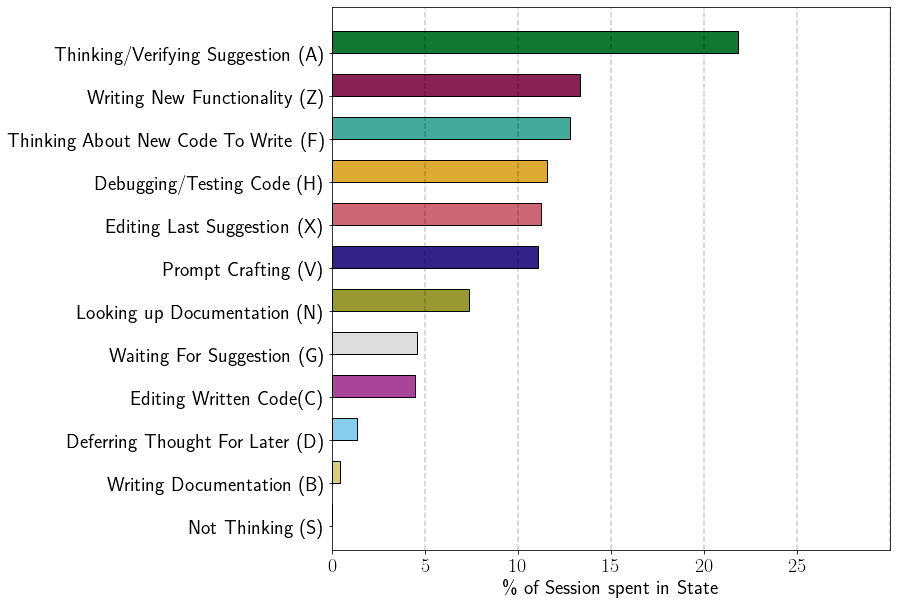

In [18]:
from tkinter import W
# sort statesfreq by frequency
statesfreq = sorted(states_freq.items(), key=lambda x: x[1], reverse=False)
# get keys sorted
statesfreq_keys = [x[0] for x in statesfreq]
print(statesfreq_keys)

plt.figure(figsize=(10, 10))

ax1 = plt.subplot(1,1,1)
y = np.arange(12)*2
w = 0.5
plt.yticks(y  , statesfreq_keys, rotation='horizontal')
error_bars = [(states_time_avg[s][3][1]-states_time_avg[s][3][0])/2 for s in statesfreq_keys]

freq = ax1.barh(y , [states_freq[s] for s in statesfreq_keys],align='edge',  alpha=1,  height = 2*w, color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black')

#time = ax1.barh(y , [states_time_avg[s][0] for s in statesfreq_keys], align='edge', xerr= error_bars,   height = w,  color=[color_mapping[s] for s in statesfreq_keys], edgecolor ='black', )
#ax2 = ax1.twiny()
ax1.set_xlabel('\% of Session spent in State', fontsize=20)

# change font size of x axis
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
# make limit of x axis the same and 0
ax1.set_xlim(0, 30)
# more ticks for ax2
ax1.set_xticks(np.arange(0, 30, 5))
# axis titles
# legend
# show vertical lines

ax1.axvline(x=5, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=10, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=15, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=20, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=25, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=30, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=35, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=40, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=45, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=50, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=55, color='black', linestyle='--', alpha=0.2)
ax1.axvline(x=60, color='black', linestyle='--', alpha=0.2)

#plt.legend([time, freq],['Average Time in State', 'Frequency'], fontsize=20)
# save with tight   
plt.savefig('histogram.pdf',dpi=1000,  bbox_inches='tight')   

# show plot
plt.show()


## Time In CUPS states

In [ ]:
all_states = []
all_actions = []
all_times = []
all_states_continuous = []
all_states_list = []
all_times_list = []

all_times_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(last_state)
            last_state = states[i]
            times_continuous.append(times_cumalitive)
            times_cumalitive = times[i]
        else:
            times_cumalitive += times[i]
    states_continuous.append(last_state)
    times_continuous.append(times_cumalitive)
    
    all_states_list.extend(states)
    all_times_list.extend(times)
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)


In [ ]:
states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used

states_count = [[0 for i in range(len(states_unique))] for _ in range(len(all_states))]
for i in range(len(all_states)):
    for j in range(len(all_states[i])):
        states_count[i][states_unique.index(all_states[i][j])] += all_times[i][j]
# normalize
states_count = [[i/sum(states_count_single)*100 for i in states_count_single] for states_count_single in states_count]
averaged_over_users = np.mean(states_count, axis=0)
# median
median = np.median(states_count, axis=0)
# get std
std = np.std(states_count, axis=0)
# print
print('Averaged Across Users \n \n')
for i in range(len(states_unique)):
    print(f' {states_unique[i]}  {averaged_over_users[i]:.2f} {std[i]:.2f}')


for each participant, see how often is verifying suggestion is the largest state

In [ ]:
# count for each list in states_count, how often the max is index 7
count_top1 = 0
count_top3 = 0
for i in range(len(states_count)):
    if np.argmax(states_count[i]) == 0:
        count_top1 += 1
        count_top3 += 1
    # second argmax is 7
    if np.argsort(states_count[i])[-2] == 0:
        count_top3 += 1
    # third argmax is 7
    if np.argsort(states_count[i])[-3] == 0:
        count_top3 += 1
    #print(states_count[i][7])

print(count_top1)
print(count_top3)


for each participant, see how often is writing code is the largest state

In [ ]:
# count for writiin
count_top1 = 0
count_top3 = 0
for i in range(len(states_count)):
    if np.argmax(states_count[i]) == 8:
        count_top1 += 1
        count_top3 += 1
    # second argmax is 7
    if np.argsort(states_count[i])[-2] == 8:
        count_top3 += 1
    # third argmax is 7
    if np.argsort(states_count[i])[-3] == 8:
        count_top3 += 1
    print(states_count[i][8])
print(count_top1)
print(count_top3)


Count how often Copilot states spend their time in

In [ ]:
# indices for copilot 0
count_top1 = 0
coderec_states_time = []
for i in range(len(states_count)):
    # sum indices at 1,2,3,5,7 of states_count[i]
    sum_coderec_states = sum([states_count[i][0], states_count[i][3], states_count[i][4], states_count[i][10], states_count[i][11]])
    print(sum_coderec_states)
    coderec_states_time.append(sum_coderec_states)
    if sum_coderec_states > 50:
        count_top1 += 1

print(f'how many more than 47percent {sum(i > 47 for i in coderec_states_time)/len(coderec_states_time)}')
print(f'how many more than 21percent {sum(i > 21 for i in coderec_states_time)/len(coderec_states_time)}')

print("COUNT TOP 1") 
print(count_top1)
print(np.mean(coderec_states_time))
print(np.median(coderec_states_time))
print(np.std(coderec_states_time))


# Section 6.2: behavior by task and experience

## By Task

In [ ]:
tasks_by_user = {'Algorithmic Problem' : [4,17,18], 'Data Manipulation': [1,2,11,20], 'Data Analysis':[5,8], 'Machine Learning':[3,7,12,15], 'Classes':[6,9], 'Writing Tests':[16],'Editing Code':[10,14,21], 'Logistic Regression':[13,19]}


all_states = []
all_actions = []
all_times = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)
all_states_by_task = {}
all_actions_by_task = {}
all_times_by_task = {}
for task in tasks_by_user:
    all_states_by_task[task] = []
    all_actions_by_task[task] = []
    all_times_by_task[task] = []
    for i in tasks_by_user[task]:
        all_states_by_task[task].extend(all_states[i-1])
        all_actions_by_task[task].extend(all_actions[i-1])
        all_times_by_task[task].extend(all_times[i-1])


In [ ]:
z = 0
for task in tasks_by_user:
    print(task)
    z += 1
    if z<= 3:
        continue
    import collections
    counter = collections.Counter(all_actions_by_task[task])
    # normalize counter
    counter_normalized = {k: v/sum(counter.values()) for k, v in counter.items()}
    print(counter)
    print(f' Accept Rate is {counter["Accepted"]/ counter["Shown"]}')
    all_actions_binary = [] 
    # for each list in all_actions, keep only Accepted and Rejected and convert to binary
    # get standard error of bernoulli
    # create list of 0s of lenght counter["Shown"]
    all_actions_binary = [0]*counter["Shown"]
    # add 1s for Accepted
    all_actions_binary[:counter["Accepted"]] = [1]*counter["Accepted"]
    print(f' Mean is {np.mean(all_actions_binary)}')
    task_num_users = len(tasks_by_user[task])
    print(f' Standard Error is {np.std(all_actions_binary)/np.sqrt(task_num_users)}')



In [ ]:
# chi square test to compare means
# NOT USED ANYMORE
from scipy.stats import chi2_contingency

counter_dm = collections.Counter(all_actions_by_task['Data Manipulation'])
counter_classes = collections.Counter(all_actions_by_task['Classes'])
table = [[counter_dm['Shown'] -counter_dm['Accepted'], counter_dm['Accepted']],[counter_classes['Shown'] -counter_classes['Accepted'], counter_classes['Accepted']]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

In [ ]:

time_distrubution_by_task = {}
for task in tasks_by_user:
    print(f' \n {task} \n')

    states_unique = list(set(all_states_continuous))
# for each session, count how many times each state is used

    states_count = [0 for i in range(len(states_unique))] 
    for i in range(len(all_states_by_task[task])):
        states_count[states_unique.index(all_states_by_task[task][i])] += all_times_by_task[task][i]
    # normalize
    states_count = [i/sum(states_count)*100 for i in states_count] 
    time_distrubution_by_task[task] = states_count
    # median
    # get std
    # print
    # get indices of the top 3 states
    top3_indices = np.argsort(states_count)[-3:]
    print(f' {states_unique[top3_indices[2]]} ({states_count[top3_indices[2]]:.2f}) newline  {states_unique[top3_indices[1]]} ({states_count[top3_indices[1]]:.2f}) newline  {states_unique[top3_indices[0]]} ({states_count[top3_indices[0]]:.2f})')
    #for i in range(len(states_unique)):
    #    print(f' {states_unique[i]}  {states_count[i]:.2f} ')


## By Expertise

In [ ]:
logs_by_user_session_labeled[3].UserExperience[0]

In [ ]:
len(logs_by_user_session_labeled)

In [ ]:


all_states = []
all_actions = []
all_times = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)

all_states_by_expertise = {'copilot_exp': [], 'no_copilot_exp': [], 'exp_prog': [], 'no_exp_prog': []}
all_actions_by_expertise= {'copilot_exp': [], 'no_copilot_exp': [], 'exp_prog': [], 'no_exp_prog': []}
all_times_by_expertise = {'copilot_exp': [], 'no_copilot_exp': [], 'exp_prog': [], 'no_exp_prog': []}
group_count = {'copilot_exp': 0, 'no_copilot_exp': 0, 'exp_prog': 0, 'no_exp_prog': 0}

for i in range(len(all_states)):
    user_charac= logs_by_user_session_labeled[i].UserExperience[0]
    if user_charac['How often do you use Copilot outside of today’s session?'] != 'Never':
        all_states_by_expertise['copilot_exp'].extend(all_states[i])
        all_actions_by_expertise['copilot_exp'].extend(all_actions[i])
        all_times_by_expertise['copilot_exp'].extend(all_times[i])
        group_count['copilot_exp'] += 1
    else:
        all_states_by_expertise['no_copilot_exp'].extend(all_states[i])
        all_actions_by_expertise['no_copilot_exp'].extend(all_actions[i])
        all_times_by_expertise['no_copilot_exp'].extend(all_times[i])
        group_count['no_copilot_exp'] += 1
    if user_charac['Which best describes your programming experience?'] in [' 3 to 5 years professional programming experience', ' 0 to 2 years professional programming experience']:
        all_states_by_expertise['no_exp_prog'].extend(all_states[i])
        all_actions_by_expertise['no_exp_prog'].extend(all_actions[i])
        all_times_by_expertise['no_exp_prog'].extend(all_times[i])
        group_count['no_exp_prog'] += 1
    else:
        all_states_by_expertise['exp_prog'].extend(all_states[i])
        all_actions_by_expertise['exp_prog'].extend(all_actions[i])
        all_times_by_expertise['exp_prog'].extend(all_times[i])
        group_count['exp_prog'] += 1

In [ ]:

for group in all_states_by_expertise:
    print(group)
    
    import collections
    counter = collections.Counter(all_actions_by_expertise[group])
    # normalize counter
    counter_normalized = {k: v/sum(counter.values()) for k, v in counter.items()}
    print(counter)
    print(f' Accept Rate is {counter["Accepted"]/ counter["Shown"]}')
    all_actions_binary = [] 
    # for each list in all_actions, keep only Accepted and Rejected and convert to binary
    # get standard error of bernoulli
    # create list of 0s of lenght counter["Shown"]
    all_actions_binary = [0]*counter["Shown"]
    # add 1s for Accepted
    all_actions_binary[:counter["Accepted"]] = [1]*counter["Accepted"]
    print(f' Mean is {np.mean(all_actions_binary)}')
    group_size = group_count[group]
    print(f' Standard Error is {np.std(all_actions_binary)/np.sqrt(group_size)}')



In [ ]:
# chi square test to compare means
# NOT USED
from scipy.stats import chi2_contingency

counter_exp = collections.Counter(all_actions_by_expertise['copilot_exp'])
counter_notexp = collections.Counter(all_actions_by_expertise['no_copilot_exp'])
table = [[counter_exp['Shown'] -counter_exp['Accepted'], counter_exp['Accepted']],[counter_notexp['Shown'] -counter_notexp['Accepted'], counter_notexp['Accepted']]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

In [ ]:
# chi square test to compare means
# NOT USED
from scipy.stats import chi2_contingency

counter_exp = collections.Counter(all_actions_by_expertise['exp_prog'])
counter_notexp = collections.Counter(all_actions_by_expertise['no_exp_prog'])
table = [[counter_exp['Shown'] -counter_exp['Accepted'], counter_exp['Accepted']],[counter_notexp['Shown'] -counter_notexp['Accepted'], counter_notexp['Accepted']]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

# Section 6.3 Defer Thought


In [ ]:
all_states = []
all_actions = []
all_times = []
all_suggestions = []
all_states_continuous = []
all_times_continuous = []
all_actions_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    suggestions = logs_by_user_session_labeled[i].CurrentSuggestion.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    actions_continuous = []
    # merge states with same name
    last_state = ""
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(states[i])
            last_state = states[i]
            times_continuous.append(times_cumalitive + times[i])
            times_cumalitive = 0
        else:
            times_cumalitive += times[i]
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)
    all_suggestions.append(suggestions)
# merge all pandas dataframes of logs_by_user_session_labeled into a single dataframe
all_users_df = pd.concat(logs_by_user_session_labeled)
all_users_df.reset_index(drop=True, inplace=True)

In [ ]:
counter_all = collections.Counter(all_states_continuous)
print(counter_all)

In [ ]:
# get suggestions in all_users_df where LabeledState is Defered Thought
defered_thought_suggestions = all_users_df[all_users_df['LabeledState'] == 'Deferring Thought For Later (D)'].CurrentSuggestion.to_numpy()
thinking_suggestions = all_users_df[all_users_df['LabeledState'] == 'Thinking/Verifying Suggestion (A)'].CurrentSuggestion.to_numpy()
# print random sample of suggestions from each 
#print('defered_thought_suggestions \n \n')
#print(defered_thought_suggestions[np.random.randint(len(defered_thought_suggestions), size=10)])
#print('thinking suggestions \n \n')
#print(thinking_suggestions[np.random.randint(len(thinking_suggestions), size=10)])

# compare number of characters and lines between the two groups
defered_thought_suggestions_characters = []
thinking_suggestions_characters = []
defered_thought_suggestions_lines = []
thinking_suggestions_lines = []
for i in range(len(defered_thought_suggestions)):
    defered_thought_suggestions_characters.append(len(defered_thought_suggestions[i]))
    defered_thought_suggestions_lines.append(len(defered_thought_suggestions[i].split('\\n')))

for i in range(len(thinking_suggestions)):
    thinking_suggestions_characters.append(len(thinking_suggestions[i]))
    thinking_suggestions_lines.append(len(thinking_suggestions[i].split('\\n')))

# print average and median number of characters and lines for each group
print(f'n = {len(defered_thought_suggestions)} Avg characters for defered thought suggestions: {np.mean(defered_thought_suggestions_characters):.2f} median characters: {np.median(defered_thought_suggestions_characters):.2f} std characters: {np.std(defered_thought_suggestions_characters):.2f}')
print(f'Avg lines for defered thought suggestions: {np.mean(defered_thought_suggestions_lines):.2f} median lines: {np.median(defered_thought_suggestions_lines):.2f} std lines: {np.std(defered_thought_suggestions_lines):.2f}')
print(f'n = {len(thinking_suggestions_characters)} Avg characters for thinking suggestions: {np.mean(thinking_suggestions_characters):.2f} median characters: {np.median(thinking_suggestions_characters):.2f} std characters: {np.std(thinking_suggestions_characters):.2f}')
print(f'Avg lines for thinking suggestions: {np.mean(thinking_suggestions_lines):.2f} median lines: {np.median(thinking_suggestions_lines):.2f} std lines: {np.std(thinking_suggestions_lines):.2f}')
# two sample t test, one for characters and one for lines
from scipy.stats import ttest_ind
print(f'ttest_ind(thinking_suggestions_characters, defered_thought_suggestions_characters) = {ttest_ind(thinking_suggestions_characters, defered_thought_suggestions_characters)}')
print(f'ttest_ind(thinking_suggestions_lines, defered_thought_suggestions_lines) = {ttest_ind(thinking_suggestions_lines, defered_thought_suggestions_lines)}')



In [ ]:
prev_states_defer = {}
prev_states_thinking = {}
for j in range(1, len(all_states)):
    for i in range(len(all_states[j])):
        if all_states[j][i] == 'Deferring Thought For Later (D)':
            if all_states[j][i-1] not in prev_states_defer:
                prev_states_defer[all_states[j][i-1]] = 1
            else:
                prev_states_defer[all_states[j][i-1]] += 1
        if all_states[j][i] == 'Thinking/Verifying Suggestion (A)':
            if all_states[j][i-1] not in prev_states_thinking:
                prev_states_thinking[all_states[j][i-1]] = 1
            else:
                prev_states_thinking[all_states[j][i-1]] += 1

# instead of counts make it a probability
sum_defer = sum(prev_states_defer.values())
for key in prev_states_defer:
    prev_states_defer[key] = prev_states_defer[key]/sum_defer
sum_thinking = sum(prev_states_thinking.values())
for key in prev_states_thinking:
    prev_states_thinking[key] = prev_states_thinking[key]/sum_thinking
    
# print
print(f'prev_states_defer = {prev_states_defer}')
print(f'prev_states_thinking = {prev_states_thinking}')


In [ ]:
counts_edits = {'Deferring Thought For Later (D)':0, 'Thinking/Verifying Suggestion (A)':0, 'Waiting For Suggestion (G)':0, 'Thinking About New Code To Write (F)':0}
counts_states = {'Deferring Thought For Later (D)':0, 'Thinking/Verifying Suggestion (A)':0, 'Waiting For Suggestion (G)':0, 'Thinking About New Code To Write (F)':0}

for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted']:
            if all_states[j][i] == 'Thinking/Verifying Suggestion (A)':
                counts_states['Thinking/Verifying Suggestion (A)'] += 1
                if all_states[j][i+1] == 'Editing Last Suggestion (X)':
                    counts_edits['Thinking/Verifying Suggestion (A)'] += 1
            if all_states[j][i] == 'Deferring Thought For Later (D)':
                counts_states['Deferring Thought For Later (D)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Deferring Thought For Later (D)'] += 1
            if all_states[j][i] == 'Waiting For Suggestion (G)':
                counts_states['Waiting For Suggestion (G)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Waiting For Suggestion (G)'] += 1
            if all_states[j][i] == 'Thinking About New Code To Write (F)':
                counts_states['Thinking About New Code To Write (F)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Thinking About New Code To Write (F)'] += 1
# print probability of edit
print(counts_edits)
print(counts_states)
print(f'Probability of edit Thinking/Verifying Suggestion (A):  {counts_edits["Thinking/Verifying Suggestion (A)"]/counts_states["Thinking/Verifying Suggestion (A)"]}')
print(f'Probability of edit Deferring Thought For Late: {counts_edits["Deferring Thought For Later (D)"]/counts_states["Deferring Thought For Later (D)"]}')
print(f'Probability of edit Thinking About New Code To Write: {counts_edits["Thinking About New Code To Write (F)"]/counts_states["Thinking About New Code To Write (F)"]}')

In [ ]:
from scipy.stats import ttest_ind
thinking_accepts = [0] * counts_states['Thinking/Verifying Suggestion (A)']
thinking_accepts[0:counts_edits['Thinking/Verifying Suggestion (A)']] = [1] * counts_edits['Thinking/Verifying Suggestion (A)']
writing_accepts = [0] * counts_states['Deferring Thought For Later (D)']
writing_accepts[0:counts_edits['Deferring Thought For Later (D)']] = [1] * counts_edits['Deferring Thought For Later (D)']
# shuffle both arrays
np.random.shuffle(thinking_accepts)
np.random.shuffle(writing_accepts)


# chi square test to compare means
from scipy.stats import chi2_contingency
table = [[counts_edits['Thinking/Verifying Suggestion (A)'], counts_states['Thinking/Verifying Suggestion (A)'] - counts_edits['Thinking/Verifying Suggestion (A)']], [counts_edits['Deferring Thought For Later (D)'], counts_states['Deferring Thought For Later (D)'] - counts_edits['Deferring Thought For Later (D)']]]

stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

In [ ]:
# accept rate before shown
states_accept = {}
states_count = {}

for j in range(len(all_states)):
    for i in range(1, len(all_states[j])):
        if all_actions[j][i] in ['Accepted', 'Rejected']:
            state_now = all_states[j][i]
            state_before = all_states[j][i-1]
            if state_before not in states_count:
                states_accept[state_before] = 0
                states_count[state_before] = 1
            else:  
                states_count[state_before] += 1
            
            if all_actions[j][i] == 'Accepted':
                states_accept[state_before] += 1


print(f'Probability of accept for each state:')
for state in states_count:
    print(f'{state}: {states_accept[state]/states_count[state]} {np.std([1]*states_accept[state] + [0]*(states_count[state] - states_accept[state]))/np.sqrt(states_count[state])}')
    

In [ ]:
# accept rate while shown
states_accept = {}
states_count = {}

for j in range(len(all_states)):
    for i in range(1, len(all_states[j])):
        if all_actions[j][i] in ['Accepted', 'Rejected']:
            state_now = all_states[j][i]
            if state_now not in states_count:
                states_count[state_now] = 1
                states_accept[state_now] = 0

            else:
                states_count[state_now] += 1
            
            if all_actions[j][i] == 'Accepted':
                states_accept[state_now] += 1

print(f'Probability of accept for each state:')
# and standard error
for state in states_count:
    print(f'{state}: {states_accept[state]/states_count[state]} {np.std([1]*states_accept[state] + [0]*(states_count[state] - states_accept[state]))/np.sqrt(states_count[state])}')
    

In [ ]:
from scipy.stats import ttest_ind
thinking_accepts = [0] * states_count['Thinking/Verifying Suggestion (A)']
thinking_accepts[0:states_accept['Thinking/Verifying Suggestion (A)']] = [1] * states_accept['Thinking/Verifying Suggestion (A)']
writing_accepts = [0] * states_count['Thinking About New Code To Write (F)']
writing_accepts[0:states_accept['Thinking About New Code To Write (F)']] = [1] * states_accept['Thinking About New Code To Write (F)']
# shuffle both arrays
np.random.shuffle(thinking_accepts)
np.random.shuffle(writing_accepts)


# chi square test to compare means
from scipy.stats import chi2_contingency
table = [[states_accept['Thinking/Verifying Suggestion (A)'], states_count['Thinking/Verifying Suggestion (A)'] - states_accept['Thinking/Verifying Suggestion (A)']], [states_accept['Thinking About New Code To Write (F)'], states_count['Thinking About New Code To Write (F)'] - states_accept['Thinking About New Code To Write (F)']]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

# Cups time to verify (section 6.4)

In [ ]:
all_states = []
all_actions = []
all_times = []
all_suggestions = []
all_states_continuous = []
all_times_continuous = []
all_actions_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    suggestions = logs_by_user_session_labeled[i].CurrentSuggestion.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    actions_continuous = []
    # merge states with same name
    last_state = ""
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(states[i])
            last_state = states[i]
            times_continuous.append(times_cumalitive + times[i])
            times_cumalitive = 0
        else:
            times_cumalitive += times[i]
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)
    all_suggestions.append(suggestions)
# merge all pandas dataframes of logs_by_user_session_labeled into a single dataframe
all_users_df = pd.concat(logs_by_user_session_labeled)
all_users_df.reset_index(drop=True, inplace=True)

In [ ]:
# for defer thought, check time after
defer_thought_original = []
defer_thought_new = []
post_thinking_time = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if  all_states[j][i] == 'Deferring Thought For Later (D)' and all_actions[j][i] == 'Accepted':
            defer_thought_original.append(all_times[j][i])
            if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                defer_thought_new.append(all_times[j][i+1]+ all_times[j][i])
                post_thinking_time.append(all_times[j][i+1])
            else:
                defer_thought_new.append(all_times[j][i])
# mean of original and new
print(f'how often verify after defer = {len(post_thinking_time)/len(defer_thought_new)}')
print(f'Defer Thought should add the thinking veriyfing suggestion time after the action n = {len(defer_thought_original)}')
print(f' (means) before adjusting: {np.mean(defer_thought_original):.2f} +- {np.std(defer_thought_original):.2f} after adjusting: {np.mean(defer_thought_new):.2f} +- {np.std(defer_thought_new):.2f}')
print(f' (median) before adjusting: {np.median(defer_thought_original):.2f} +- {np.std(defer_thought_original):.2f} after adjusting: {np.median(defer_thought_new):.2f} +- {np.std(defer_thought_new):.2f}')
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
print(f' post thinking time (means) {np.mean(post_thinking_time):.2f} +- {np.std(post_thinking_time):.2f} occurs {len(post_thinking_time)/len(defer_thought_new)}')
# paired t-test
import scipy
def paired_ttest(a, b):
    return scipy.stats.ttest_rel(a, b)
print(paired_ttest(defer_thought_original, defer_thought_new))

In [ ]:
# for thinking , check time after
thinking_original = []
thinking_new = []
post_thinking_time = []

for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if  all_states[j][i] == 'Thinking/Verifying Suggestion (A)' and all_actions[j][i] == 'Accepted':
            thinking_original.append(all_times[j][i])
            new_time = all_times[j][i]
            if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                new_time += all_times[j][i+1]
                post_thinking_time.append(all_times[j][i+1])

            #if all_states[j][i-1] == 'Waiting For Suggestion (G)':
            #    new_time += all_times[j][i-1]
            thinking_new.append(new_time)
# mean of original and new

# print
print(f' post thinking time (means) {np.mean(post_thinking_time):.2f} +- {np.std(post_thinking_time):.2f} occurs {len(post_thinking_time)/len(thinking_new)}')

print(f'Thinking should add  and time spent thinking after   n={len(thinking_new)} ')
print(f'(means) before adjusting: {np.mean(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.mean(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(f' (median) before adjusting: {np.median(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.median(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(paired_ttest(thinking_original, thinking_new))

In [ ]:
thinking_original = []
thinking_new = []
waiting_time = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted', 'Rejected'] and all_states[j][i] in ['Thinking/Verifying Suggestion (A)',
                'Waiting For Suggestion (G)', 'Deferring Thought For Later (D)', 'Thinking About New Code To Write (F)']:
            thinking_original.append(all_times[j][i])
            new_time = all_times[j][i]
            if all_states[j][i-1] == 'Waiting For Suggestion (G)':
                waiting_time.append(all_times[j][i-1])
                new_time += all_times[j][i-1]
            thinking_new.append(new_time)
# mean of original and new

# print
print(f'Thinking should add  the time spent waiting before  n={len(thinking_new)} ')
print(f'(means) before adjusting: {np.mean(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.mean(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(f' (median) before adjusting: {np.median(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.median(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(paired_ttest(thinking_original, thinking_new))
print(f' waiting time {np.mean(waiting_time):.2f} +- {np.std(waiting_time):.2f} and probability {len(waiting_time)/len(thinking_new)}')

# Prompt Crafting Insights

In [ ]:
all_states = []
all_actions = []
all_times = []
all_suggestions = []
all_states_continuous = []
all_times_continuous = []
all_actions_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    suggestions = logs_by_user_session_labeled[i].CurrentSuggestion.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    actions_continuous = []
    # merge states with same name
    last_state = ""
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(states[i])
            last_state = states[i]
            times_continuous.append(times_cumalitive + times[i])
            times_cumalitive = 0
        else:
            times_cumalitive += times[i]
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)
    all_suggestions.append(suggestions)
# merge all pandas dataframes of logs_by_user_session_labeled into a single dataframe
all_users_df = pd.concat(logs_by_user_session_labeled)
all_users_df.reset_index(drop=True, inplace=True)

In [ ]:
# probability of accept while prompt crafting
prompt_crafting_count = 0
accepted_when_prompt_crafting = 0
for j in range(len(all_states)):
    for i in range(1, len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted', 'Rejected']:
            if all_states[j][i] == 'Prompt Crafting (V)':
                prompt_crafting_count += 1
                if all_actions[j][i] == 'Accepted':# and all_states[j][i+1] == 'Prompt Crafting (V)':
                        accepted_when_prompt_crafting += 1

print(f'n = {prompt_crafting_count} Probability of accept while prompt crafting: {accepted_when_prompt_crafting/prompt_crafting_count}')

In [ ]:
# start prompt crafting - inside should be anything but 
prompt_crafting_count = 0
accepted_when_prompt_crafting = 0
for j in range(len(all_states)):
    i = 0
    while i < len(all_states[j]):
        if all_states[j][i] == 'Prompt Crafting (V)':
            # get state where prompt crafting ends
            prompt_crafting_count += 1
            last_episode_state = i
            first_pos_accept = -1
            for k in range(i, len(all_states[j]) ):
                if all_actions[j][k] == 'Accepted':
                    first_pos_accept = k
                    break

            for k in range(i, len(all_states[j])):
                if all_states[j][k] in ['Writing New Functionality (Z)', 'Editing Written Code(C)','Thinking About New Code To Write (F)','Debugging/Testing Code (H)', 'Looking up Documentation (N)', 'Writing Documentation (B)']:
                    # this means prompt crafting ended, let's check if there was an accept just before prompt crafting ended
                    last_episode_state = k
                    break

            last_prompt_state = i
            while all_states[j][last_prompt_state] == 'Prompt Crafting (V)' and last_prompt_state < len(all_states[j]) -1:
                last_prompt_state += 1
            last_prompt_state -= 1

            if first_pos_accept < max(last_prompt_state,last_episode_state):
                accepted_when_prompt_crafting += 1
                
            i = max(last_episode_state,last_prompt_state) +1
            # print the trajectory
        else:
            i += 1

print(f'n = {prompt_crafting_count} Probability of accept after prompt crafting: {accepted_when_prompt_crafting/prompt_crafting_count}')

# Transitions between states

In [3]:
from entropy_utils import *

In [4]:
all_states = []
all_actions = []
all_times = []
all_states_continuous = []
all_states_list = []
all_times_list = []

all_times_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'Edditing Last Suggestion (X)':
            states[j] = 'Editing Last Suggestion (X)'
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(last_state)
            last_state = states[i]
            times_continuous.append(times_cumalitive)
            times_cumalitive = times[i]
        else:
            times_cumalitive += times[i]
    states_continuous.append(last_state)
    times_continuous.append(times_cumalitive)
    
    all_states_list.extend(states)
    all_times_list.extend(times)
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)


In [5]:
T = pd.crosstab(
    pd.Series(all_states_continuous[:-1], name='Today'),
    pd.Series(all_states_continuous[1:], name='Tomorrow'),
    normalize=0
)


graph = TransGraph(T)
nodes_original = list(graph.dataframe.index)
transition_matrix = np.array(graph.dataframe)
nodes = list(graph.dataframe.index)


In [10]:
for i, from_state in enumerate(nodes_original):
    for j, to_state in enumerate(nodes_original):
        print(f"Probability from {from_state} to {to_state}: {transition_matrix[i][j]}")


Probability from Debugging/Testing Code (H) to Debugging/Testing Code (H): 0.0
Probability from Debugging/Testing Code (H) to Deferring Thought For Later (D): 0.05714285714285714
Probability from Debugging/Testing Code (H) to Editing Last Suggestion (X): 0.0
Probability from Debugging/Testing Code (H) to Editing Written Code(C): 0.17142857142857143
Probability from Debugging/Testing Code (H) to Looking up Documentation (N): 0.0
Probability from Debugging/Testing Code (H) to Not Thinking (S): 0.0
Probability from Debugging/Testing Code (H) to Prompt Crafting (V): 0.17142857142857143
Probability from Debugging/Testing Code (H) to Thinking About New Code To Write (F): 0.05714285714285714
Probability from Debugging/Testing Code (H) to Thinking/Verifying Suggestion (A): 0.3142857142857143
Probability from Debugging/Testing Code (H) to Waiting For Suggestion (G): 0.0
Probability from Debugging/Testing Code (H) to Writing Documentation (B): 0.0
Probability from Debugging/Testing Code (H) to W

In [6]:
# find most probable transition from each state
# find most probable transition from each state

for i in range(len(transition_matrix)):
    # find max value in ro
    max_val = max(transition_matrix[i])
    # find index of max value in row
    max_val_index = transition_matrix[i].tolist().index(max_val)
    # add to dict
    print(f' {nodes[i]} --- {transition_matrix[i][max_val_index]:.2f} ---> {nodes[max_val_index]}')

 Debugging/Testing Code (H) --- 0.31 ---> Thinking/Verifying Suggestion (A)
 Deferring Thought For Later (D) --- 0.54 ---> Thinking/Verifying Suggestion (A)
 Editing Last Suggestion (X) --- 0.26 ---> Thinking About New Code To Write (F)
 Editing Written Code(C) --- 0.29 ---> Writing New Functionality (Z)
 Looking up Documentation (N) --- 0.40 ---> Prompt Crafting (V)
 Not Thinking (S) --- 1.00 ---> Writing New Functionality (Z)
 Prompt Crafting (V) --- 0.54 ---> Thinking/Verifying Suggestion (A)
 Thinking About New Code To Write (F) --- 0.33 ---> Writing New Functionality (Z)
 Thinking/Verifying Suggestion (A) --- 0.26 ---> Writing New Functionality (Z)
 Waiting For Suggestion (G) --- 0.51 ---> Thinking/Verifying Suggestion (A)
 Writing Documentation (B) --- 0.22 ---> Thinking/Verifying Suggestion (A)
 Writing New Functionality (Z) --- 0.59 ---> Thinking/Verifying Suggestion (A)


In [7]:
mu = stationary_distribution(transition_matrix)
# get entropy rate of the MC
entropy_rate = np.dot(mu.transpose(), local_entropy(transition_matrix))
print(entropy_rate)

[2.43790289]


In [ ]:

uniform_transition_matrix = np.ones((len(transition_matrix), len(transition_matrix)))/len(transition_matrix)

mu = stationary_distribution(uniform_transition_matrix)
# uniform transition matrix
# get entropy rate of the MC
entropy_rate = np.dot(mu.transpose(), local_entropy(uniform_transition_matrix))
print(entropy_rate)

In [ ]:

# find most probable transition from each state
nodes_original = list(graph.dataframe.index)

for i in range(len(transition_matrix)):
    # find top 2 values in row
    top_2_values = sorted(transition_matrix[i], reverse=True)[:2]
    # find indices of top 2 values in row
    top_2_values_indices = [transition_matrix[i].tolist().index(x) for x in top_2_values]

    # add to dict
    print(f' {nodes_original[i]} --- {transition_matrix[i][top_2_values_indices[1]]:.2f} ---> {nodes_original[top_2_values_indices[1]]}')

In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 3
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_continuous[i:i+N]) for i in range(len(all_states_continuous)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(10)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


In [ ]:
all_states_augmented = [] 
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    # merge states with same name
    last_state = states[0]
    times_cumalitive = 0
    for i in range(len(states)):
        all_states_augmented.append(states[i])
        if actions[i] != 'Replay':
            all_states_augmented.append(actions[i])

In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 6
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_augmented[i:i+N]) for i in range(len(all_states_augmented)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(50)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


In [ ]:
# find most probable sequences
from scipy.stats import itemfreq
N = 5
def list_to_string(lst):
    return ' -> '.join(lst)
grams = [list_to_string(all_states_augmented[i:i+N]) for i in range(len(all_states_augmented)-N)]
# counter from grams
from collections import Counter
counter_grams = Counter(grams)
# get most common grams
most_common_grams = counter_grams.most_common(10)
# print each on new line
for i in range(len(most_common_grams)):
    print(most_common_grams[i])


In [ ]:
# p value correction
p_values = [0.56,0,0,8*10**-6,4*10**-5]
from statsmodels.stats.multitest import multipletests
multipletests(p_values, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)